<font size="6"> **Model Building: Hyperparam Tunning** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")
pd.set_option('precision', 4)

In [3]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)


In [4]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(OUTPATH + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(OUTPATH + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

# Scoring Function

In [8]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

In [9]:
(y_train_smp>0).value_counts()

True     32349
False    25044
Name: target, dtype: int64

# Ridge Models

In [38]:
ridge_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [39]:
hpgrid_ridge = {'alpha': [10.0**x for x in range(-3,3)]}
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [40]:
ridge_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_smp, return_train_score=True)
res_ridge_cv = ridge_cv.fit(X_train_smp[features_nov], y_train_smp)

In [41]:
ridge_params_df = pd.DataFrame(res_ridge_cv.cv_results_['params'])
ridge_metrics_df = pd.DataFrame(res_ridge_cv.cv_results_)[select_sum_cols]
ridge_sum_df = ridge_params_df.join(ridge_metrics_df)
ridge_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
3,1.000,0.4322,0.0339,1,0.5621,0.7650,0.3025,-0.0289
4,10.000,0.4204,0.0365,2,0.5564,0.7989,0.2466,-0.0286
2,0.100,0.4175,0.0114,3,0.5540,0.7867,0.2585,-0.0288
0,0.001,0.4101,0.0201,4,0.5465,0.7807,0.2510,-0.0312
1,0.010,0.4081,0.0107,5,0.5476,0.7989,0.2299,-0.0290
5,100.000,0.3887,0.0054,6,0.5506,0.9397,0.0616,-0.0285


In [42]:
select_cvdet_cols = ['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy', 'mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                    'mean_test_accuracy', 'mean_test_neg_root_mean_squared_error']

In [51]:
champ_ridge_idx = 2
champ_ridge_hparms = res_ridge_cv.cv_results_['params'][champ_ridge_idx]
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**champ_ridge_hparms)
champ_ridge.fit(X_train_smp[features_nov], y_train_smp)

Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [44]:
p_test_ridge = pd.Series(index=y_test_full.index, data=champ_ridge.predict(X_test_full))

In [45]:
ridge_metrics_cvdet =  pd.DataFrame(res_ridge_cv.cv_results_)[select_cvdet_cols]
ridge_metrics_cvdet['alpha'] = ridge_params_df['alpha']

In [46]:
champ_ridge_score = ridge_metrics_cvdet.loc[champ_ridge_idx,'mean_test_w_accuracy']
champ_ridge_alpharank = ridge_metrics_cvdet.loc[champ_ridge_idx, 'alpha']
top_ridge_score = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
top_ridge_alpharank = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'alpha'].iloc[0]
champ_ridge_score, champ_ridge_alpharank, top_ridge_score, top_ridge_alpharank

(0.41745307428114, 0.1, 0.4322064825590568, 1.0)

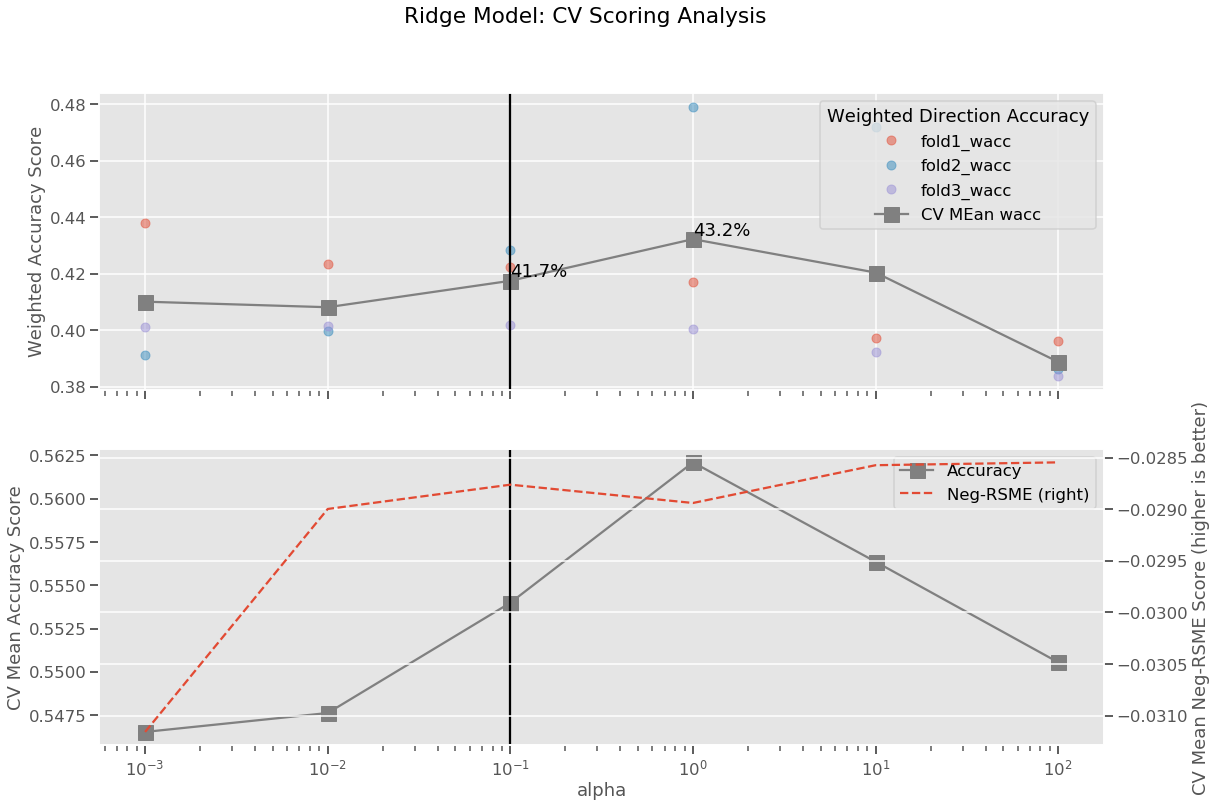

In [47]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Ridge Model: CV Scoring Analysis")
ax = axs[0]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        logx=True, style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_w_accuracy',
                        logx=True, marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(top_ridge_alpharank, top_ridge_score, f'{top_ridge_score:0.1%}', va='bottom', ha='left')
ax.text(champ_ridge_alpharank, champ_ridge_score, f'{champ_ridge_score:0.1%}', va='bottom', ha='left')

ax = axs[1]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        logx=True,marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--',
                        logx=True)

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')

for ax in axs:
    ax.axvline(x=champ_ridge_alpharank, color='black')
    
plt.show()


There are several models that may be nice to select, model ranked 2 (alpha=0.1) is a good choice:
* Hyperparameter Discusion:
    * `alpha=0.1`: Alpha is a regularization parameter, the higher its value, the more that model coefficient shrinked, when alpha=0, Ridge model is the same as a regular Linear Regression. Increasing alpha allows the model to accomodate slightly correlated features as well as, avoiding overfitting
* The best performant model is at `alpha=1`, however, cv score yield the highest standard deviation, that means that in test dataset, this score estimation may not be accurate.
* On the other hand, higher regularization means that the model tends to generalize better. However, looking at `fold2_wacc`, it is the best among any alpha, that means that `alpha=1` is the best only for that fold, skewing the mean cv. Better to look at other models


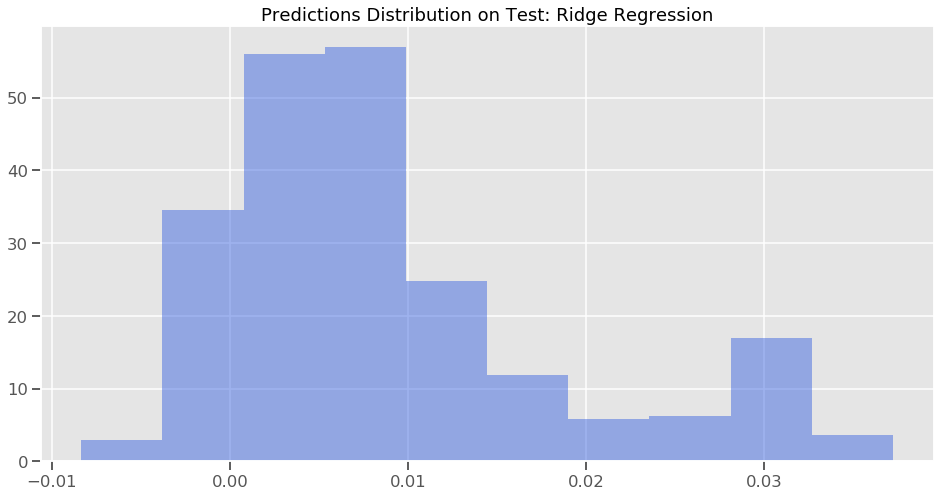

In [52]:
p_test_ridge.hist(density=True, color='royalblue', alpha=0.5)
plt.title('Predictions Distribution on Test: Ridge Regression')
plt.show()

In [53]:
ridge_sum_df = mle_utils.predict_and_score(champ_ridge,
                                           X_train_full[features_nov], y_train_full,
                                           X_test_full[features_nov], y_test_full, kind='reg')
rename_cols = {'valid_acc': 'test_acc',
           'valid_acc_target<0': 'test_acc_target<0',
           'valid_acc_target>0': 'test_acc_target>0'}
ridge_sum_df.rename(inplace=True, index=rename_cols)
ridge_sum_df

train_pmean           0.0037
train_score           0.0008
valid_pmean           0.0090
valid_score           0.0015
train_acc_target<0    0.3145
train_acc_target>0    0.7766
train_acc             0.5744
test_acc              0.5097
test_acc_target<0     0.1416
test_acc_target>0     0.8708
dtype: float64

# Random Forest Model

In [24]:
rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [25]:
hpgrid_rf = {'max_samples': [0.5, 0.75],
            'max_features': [0.25, 0.5, 0.75],
            'min_samples_leaf': [250, 500, 1000, 2500]}
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [26]:
rf_cv = GridSearchCV(rf, hpgrid_rf, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_cv = rf_cv.fit(X_train_smp, y_train_smp)

In [27]:
rf_params_df = pd.DataFrame(res_rf_cv.cv_results_['params'])
rf_metrics_df = pd.DataFrame(res_rf_cv.cv_results_)[select_sum_cols]
rf_sum_df = rf_params_df.join(rf_metrics_df)
rf_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
21,0.75,0.75,500,0.4395,0.0287,1,0.5088,0.4122,0.6308,-0.0289
17,0.75,0.50,500,0.4368,0.0266,2,0.4998,0.3712,0.6621,-0.0289
18,0.75,0.50,1000,0.4277,0.0291,3,0.4988,0.4130,0.6090,-0.0288
9,0.50,0.50,500,0.4220,0.0272,4,0.4977,0.4333,0.5788,-0.0287
20,0.75,0.75,250,0.4218,0.0415,5,0.5359,0.6635,0.3750,-0.0287
16,0.75,0.50,250,0.4204,0.0357,6,0.5237,0.5921,0.4384,-0.0287
13,0.50,0.75,500,0.4160,0.0315,7,0.4996,0.4721,0.5336,-0.0287
22,0.75,0.75,1000,0.4128,0.0441,8,0.4852,0.4123,0.5816,-0.0289
0,0.25,0.50,250,0.4100,0.0224,9,0.5207,0.6313,0.3780,-0.0285
5,0.25,0.75,500,0.4098,0.0224,10,0.5207,0.6337,0.3752,-0.0285


In [29]:
champ_rf_idx = 17
champ_rf_hparms = res_rf_cv.cv_results_['params'][champ_rf_idx]
champ_rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)
champ_rf.set_params(**champ_rf_hparms)
champ_rf.fit(X_train_smp, y_train_smp)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=500,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [30]:
p_test_rf = pd.Series(index=y_test_full.index, data=champ_rf.predict(X_test_full))

In [31]:
rf_metrics_cvdet =  pd.DataFrame(res_rf_cv.cv_results_)[select_cvdet_cols]
rf_metrics_cvdet = rf_metrics_cvdet.join(rf_params_df)
rf_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.3945,0.4416,0.3939,0.410,0.0224,9,0.5207,-0.0285,0.25,0.5,250
1,0.4099,0.4122,0.3929,0.405,0.0086,16,0.5250,-0.0285,0.25,0.5,500


In [32]:
rf_metrics_cvdet_top = rf_metrics_cvdet.sort_values(by='rank_test_w_accuracy').head(10)
hparams_tb = rf_metrics_cvdet_top.pivot_table(index='rank_test_w_accuracy', values=['max_features', 'max_samples', 'min_samples_leaf']).T

In [33]:
champ_rf_score = rf_metrics_cvdet.loc[champ_rf_idx,'mean_test_w_accuracy']
champ_rf_rank = rf_metrics_cvdet.loc[champ_rf_idx, 'rank_test_w_accuracy']
top_rf_score = rf_metrics_cvdet.loc[rf_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
champ_rf_score, champ_rf_rank, top_rf_score

(0.4368488310398259, 2, 0.43946843856696427)

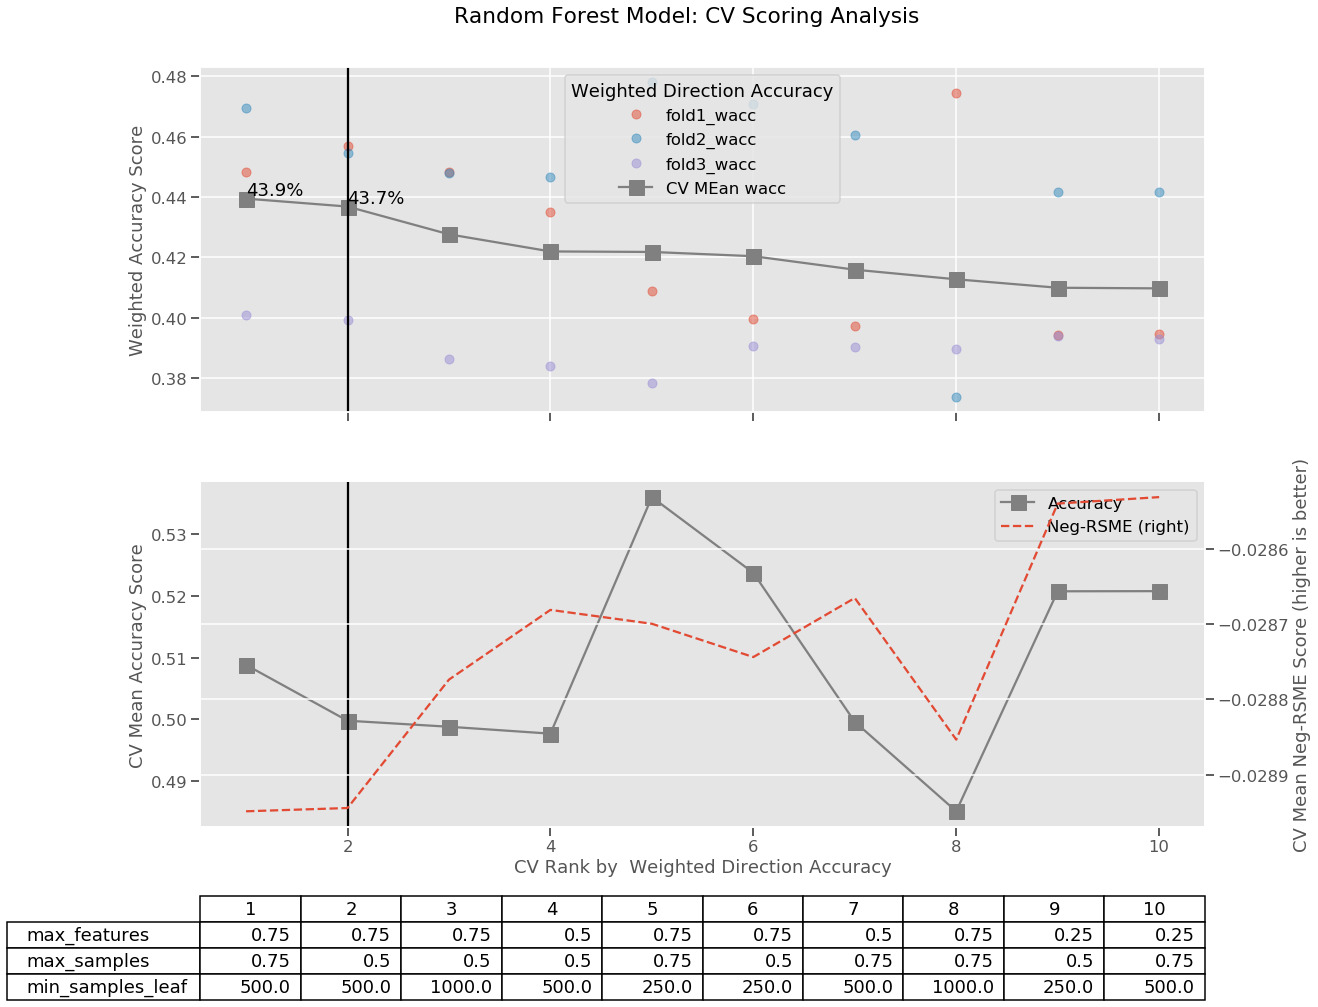

In [34]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Random Forest Model: CV Scoring Analysis", y=0.95)
ax = axs[0]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_w_accuracy',
                        marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(1, top_rf_score, f'{top_rf_score:.1%}', va='bottom', ha='left')
ax.text(champ_rf_rank, champ_rf_score, f'{champ_rf_score:.1%}', va='bottom', ha='left')

ax = axs[1]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--')

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')
ax.set_xlabel('CV Rank by  Weighted Direction Accuracy')

rf_metrics_cvdet_top_tb = ax.table(cellText=hparams_tb.astype(str).values,
                      rowLabels=hparams_tb.index.tolist(),
                      colLabels=hparams_tb.columns.tolist(),
                      loc='bottom',bbox=[0., -.5, 1., .3])#[left, bottom, width , height]

rf_metrics_cvdet_top_tb.auto_set_font_size(True)

for ax in axs:
    ax.axvline(x=champ_rf_rank, color='black')
plt.subplots_adjust(bottom=0.)


plt.show()


There are several models that may be nice to select, model ranked 6 (max_features=0.75, max_samples=0.75, min_samles_leaf=1000) is a good choice:
* Hyperparameters discussion:
    * `max_features=0.75` means that 75% features will be considered at each split (on each tree). In general, this is quite high, however, there are many OHE variables and each skelarn tree is binary, therefore, the general rule of sqrt(n_features) should be checked.
    * `max_samples=0.5` implies that each tree is built on a bootstrapped sample of 50% size. This parameter was recenty added (in sklearn 0.22)
    * Both `max_features` and `max_samples` controls regularization: the lower they are, the less correlated that each decision tree will be; in general, this allows to avoid overfitting, however, also makes individual trees less and less powerfull
    * `min_samples_leaf=500` indirectly controls tree depth, by not allowing leaves to be too small; a size of 500 means that there is a day size of observations (Stocks). The deeper a tree, the greater chances of overfitting, all in all, if leaves are very small, spurious patterns may be spot
* The top ranked model is slightly less regularized and performance scores are quite similar (regarding selected model), sadly, dispersion on CV scores is quite high.

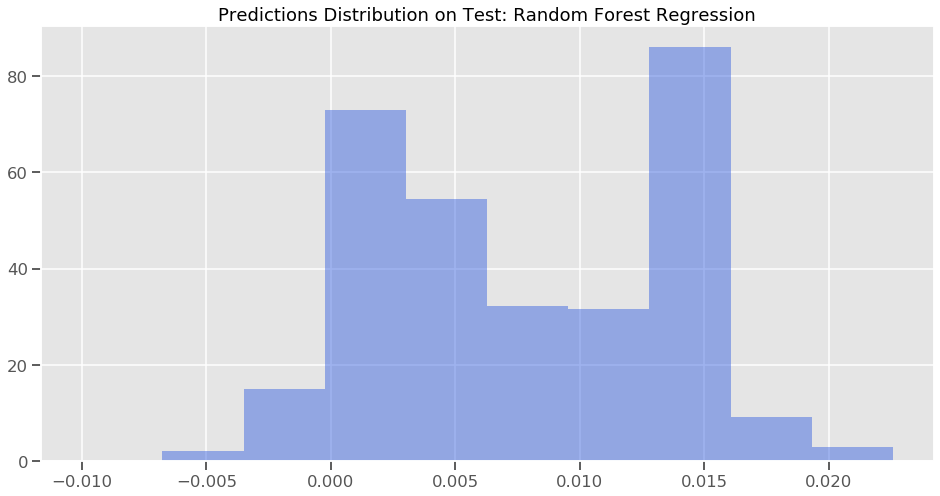

In [35]:
p_test_rf.hist(density=True, color='royalblue', alpha=0.5)
plt.title('Predictions Distribution on Test: Random Forest Regression')
plt.show()

In [36]:
rf_sum_df = mle_utils.predict_and_score(champ_rf,
                                        X_train_full, y_train_full,
                                        X_test_full, y_test_full, kind='reg')
rf_sum_df.rename(inplace=True, index=rename_cols)
rf_sum_df

train_pmean           0.0036
train_score           0.0007
valid_pmean           0.0079
valid_score           0.0014
oob_score             0.1403
train_acc_target<0    0.5217
train_acc_target>0    0.7820
train_acc             0.6681
test_acc              0.5193
test_acc_target<0     0.0800
test_acc_target>0     0.9502
dtype: float64